# Neural Networks in ``PyTorch``

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

<img src="files/figures/mnist.png" width="600px"/>

We will define and train a deep neural network on the MNIST dataset. This is a **classification problem**.<br>

The definition and training of a neural network invoves the following steps:

0. Import **librairies**;
1. Get the **datasets** (train, validation and test);
2. Define the **dataloaders** from the datasets (train and test);
3. Define the **model**;
4. Define the **loss function**;
5. Define the **optimizer**;
7. **Train** the model (training loop);
8. Get the **results** (predict).

## 0. Librairies

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## 1. Datasets

- Load the train and test MNIST datasets using the following commands:<br>
```
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
```
Each sample consists of a tensor (the image encoded in black and white), and a label (the digit that it represents).

- Examine the data (structure, dimension, etc).
- Create a function to visualize some data as an image.

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [50000,10000])

In [4]:
len(train_dataset), len(val_dataset), len(test_dataset)

(50000, 10000, 10000)

In [5]:
# Each sample data is a tuple: tensor [1, 28, 28], label
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([1, 28, 28]), 1)

In [6]:
def display_data(sample):
    
    # get tensor and label
    tensor, label = sample[0], sample[1]
    tensor = tensor.view(28, 28) # reshape into 28 x 28
    
    # plot
    plt.figure(figsize=(2, 2))
    plt.title(f'label: {label}')
    plt.imshow(tensor)
    plt.show()

In [7]:
def display_some_data(dataset):
    
    fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
    for i in range(25):
        
        tensor, label = dataset[i][0], dataset[i][1]
        
        axs[i//5, i%5].set_title(f"Label: {label}")
        axs[i//5, i%5].imshow(tensor.view(28, 28))
    
    plt.show()

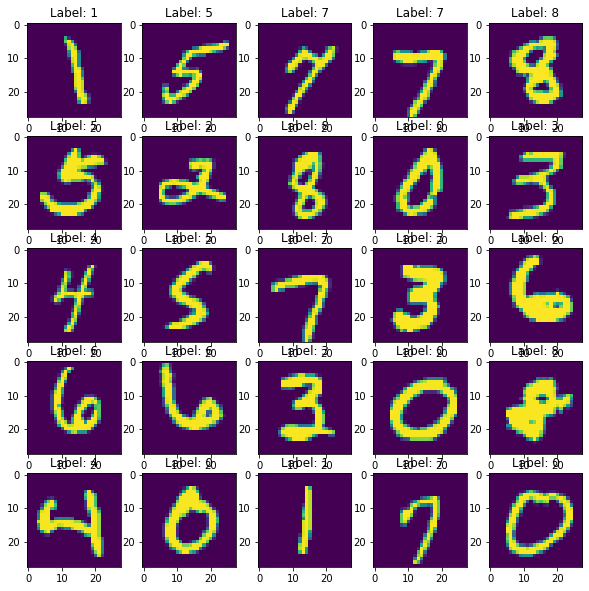

In [8]:
display_some_data(train_dataset)

## 2. Dataloaders

A **dataloader** creates batches of samples from a dataset so that they can be passed into a model.
- Create a train and test dataloaders using the following commands:
```
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
```
- Note that dataloaders are not subscriptable.
- Try to catch one batch of the dataloader and examine it.
- Write a function that reshapes a batch of size $64 \times 1 \times 28 \times 28$ into a tensor of size $64 \times 784$.<br>
(use `torch.squeeze()`, `torch.reshape()`, `torch.flatten()`, `torch.transpose()`, etc.)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [10]:
def reshape_batch(batch):
    
    # note that this function moodifies the batch in-place (no return)
    batch_size = batch[0].shape[0]
    batch[0] = batch[0].view(batch_size, -1)
    
    return batch

In [11]:
for b in train_dataloader:
    break

In [12]:
b[0].shape

torch.Size([64, 1, 28, 28])

In [13]:
reshape_batch(b)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 6, 0, 6, 4, 2, 6, 3, 3, 0, 1, 1, 6, 8, 1, 9, 1, 8, 1, 9, 4, 3, 3, 3,
         9, 6, 1, 0, 1, 7, 0, 1, 2, 9, 3, 9, 4, 9, 7, 7, 8, 9, 2, 7, 9, 9, 5, 6,
         5, 3, 7, 3, 6, 9, 1, 7, 5, 1, 2, 0, 0, 1, 0, 1])]

In [14]:
b[0].shape

torch.Size([64, 784])

## 3. Model

- Define and instanciate a **neural network** with the following feaures:
    - hidden layer 1: 256 neurons, relu activation function
    - hidden layer 2: 256 neurons, relu activation function
    - hidden layer 3: 128 neurons, relu activation function
    - hidden layer 4: 64 neurons, relu activation function
    - output layer: 10 neurons

In [15]:
class Network(nn.Module):

    def __init__(self):
        
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        
        x = self.fc3(x)
        x = nn.ReLU()(x)
        
        x = self.fc4(x)
        x = nn.ReLU()(x)
        
        x = self.fc5(x)
        
        return x

In [16]:
network = Network()

In [17]:
# Put network to GPU if exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

In [18]:
network

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

## 4. Loss

- Define a **cross entropy loss** with the following command:<br>
```
loss = nn.CrossEntropyLoss()
```
- Try to understand this loss object:<br>
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [19]:
loss = nn.CrossEntropyLoss()

## 5. Optimizer

- Define an **SGD optimizer** with the following command:<br>
```
optimizer = torch.optim.SGD(network.parameters(), lr=0.005)
```
- Try to understand this object:<br>
https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

In [20]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.005)

## 6. Training

- Define a **training loop** for you model.
- The key instructions are:
    - ``optimizer.zero_grad()``: reset gradients to 0
    - ``loss.backward()``      : compute new gradients
    - ``optimizer.step()``     : uptdate weights
- Train the model for 20 epochs.
- Plot the training loss.

In [21]:
def train(model, loss=None, optimizer=None, train_dataloader=None, val_dataloader=None, nb_epochs=20):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):

        # Training
        train_loss = 0.0

        for data, labels in train_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            # Reset gradients to 0
            optimizer.zero_grad()

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute training loss
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Compute gradients
            current_loss.backward()

            # Update weights
            optimizer.step()
        
        # Validation
        val_loss = 0.0

        # Put model in eval mode
        model.eval()

        for data, labels in val_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute validation loss
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()
        
        # Prints
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")
        
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Save model if val loss decreases
        if val_loss < min_val_loss:

            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            
    return train_losses, val_losses

In [22]:
train_losses, val_losses = train(model=network, loss=loss, optimizer=optimizer, 
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                                 nb_epochs=20)

Epoch 1/20                 	 Training Loss: 2.304                 	 Validation Loss: 2.301
Epoch 2/20                 	 Training Loss: 2.298                 	 Validation Loss: 2.294
Epoch 3/20                 	 Training Loss: 2.290                 	 Validation Loss: 2.284
Epoch 4/20                 	 Training Loss: 2.271                 	 Validation Loss: 2.251
Epoch 5/20                 	 Training Loss: 2.182                 	 Validation Loss: 2.042
Epoch 6/20                 	 Training Loss: 1.694                 	 Validation Loss: 1.249
Epoch 7/20                 	 Training Loss: 0.926                 	 Validation Loss: 0.751
Epoch 8/20                 	 Training Loss: 0.677                 	 Validation Loss: 0.643
Epoch 9/20                 	 Training Loss: 0.598                 	 Validation Loss: 0.584
Epoch 10/20                 	 Training Loss: 0.546                 	 Validation Loss: 0.539
Epoch 11/20                 	 Training Loss: 0.502                 	 Validation Loss: 0.5

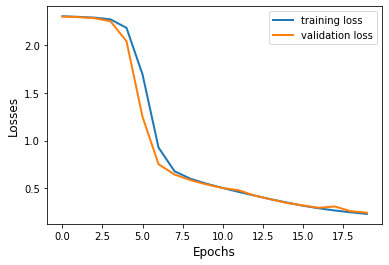

In [34]:
# Plot losses
plt.plot(range(len(train_losses)), train_losses, 
         linewidth=2.0, 
         label='training loss')

plt.plot(range(len(val_losses)), val_losses, 
         linewidth=2.0, 
         label='validation loss')

plt.xlabel("Epochs", size=12)
plt.ylabel("Losses", size=12)
plt.legend()

plt.savefig('figures/losses.pdf') 
plt.show()

## 6. Testing

- Write a ``predict`` function
    - use ``with torch.no_grad():``
- Compute the accuracy and classification report of the train and test sets.

In [24]:
def predict(model, test_dataloader):

    labels_l = []
    preds_l = []
    
    # Put model in eval mode
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloader):
            
            data, labels = reshape_batch(batch)
            
            labels_l.extend(labels.tolist())
            
            preds = model(data)
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [25]:
train_labels, train_preds = predict(network, train_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [26]:
print(classification_report(train_labels, train_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9681    0.9710    0.9695      4932
           1     0.9582    0.9736    0.9658      5634
           2     0.9496    0.9150    0.9320      4944
           3     0.9494    0.9103    0.9294      5128
           4     0.9027    0.9646    0.9326      4893
           5     0.8737    0.9313    0.9016      4529
           6     0.9502    0.9681    0.9591      4927
           7     0.9592    0.9341    0.9464      5156
           8     0.9275    0.8871    0.9069      4900
           9     0.9095    0.8923    0.9008      4957

    accuracy                         0.9352     50000
   macro avg     0.9348    0.9347    0.9344     50000
weighted avg     0.9358    0.9352    0.9352     50000



In [27]:
print(classification_report(test_labels, test_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9573    0.9827    0.9698       980
           1     0.9711    0.9780    0.9745      1135
           2     0.9428    0.9109    0.9266      1032
           3     0.9456    0.9297    0.9376      1010
           4     0.9035    0.9633    0.9325       982
           5     0.8645    0.9226    0.8926       892
           6     0.9415    0.9572    0.9493       958
           7     0.9573    0.9163    0.9364      1028
           8     0.9263    0.8645    0.8943       974
           9     0.9095    0.8969    0.9032      1009

    accuracy                         0.9327     10000
   macro avg     0.9319    0.9322    0.9317     10000
weighted avg     0.9333    0.9327    0.9326     10000



## 7. Save

- Save your trained model.
- Try to reload it and see if it works.
- Use the following instructions
```
torch.save(model.state_dict(), <path>)
...
network_2.load_state_dict(torch.load(<path>))
network_2.eval()
```

In [28]:
cwd = os.getcwd()
path = os.path.join(cwd, "model.pt")
path_2 = os.path.join(cwd, "best_model.pt")

In [29]:
# Save last model
torch.save(network.state_dict(), path) 

In [30]:
# Load best model
network_2 = Network()

network_2.load_state_dict(torch.load(path))
network_2.eval()

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

In [31]:
test_labels, test_preds = predict(network_2, test_dataloader)

In [32]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.94      0.91      0.93      1032
           3       0.95      0.93      0.94      1010
           4       0.90      0.96      0.93       982
           5       0.86      0.92      0.89       892
           6       0.94      0.96      0.95       958
           7       0.96      0.92      0.94      1028
           8       0.93      0.86      0.89       974
           9       0.91      0.90      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

